In [57]:
import scipy.io as sio
import numpy as np 
import sys 
from matplotlib import pyplot as plt
from numba import jit

from sklearn.decomposition import NMF


from itertools import permutations


In [58]:
# #145 145 220
# def main():
#     # See https://rslab.ut.ac.ir/data for information about this dataset (Urban)
#     hs_image = sio.loadmat("data/Urban_R162.mat")
#     # print(type(hs_image))

#     # for key in hs_image:
#     #     print(key)

#     # Channels that are kept 
#     # print(hs_image["SlectBands"])

#     # Size of image 
#     # print(hs_image["nRow"])
#     # print(hs_image["nCol"])

#     # Number of wavelengths 
#     # print(hs_image["nBand"])

#     # Matrix itself 
#     # print(hs_image["Y"])

#     # Not sure what this mean 
#     # print(hs_image["maxValue"])

    
#     matrix = np.array(hs_image["Y"])

#     # Each row correspond to a channel/wavelength and the image is vectorized as a row vector (I am not sure how it is being flatten) 
#     # I am not sure what the value in the matrix mean. They range from 0 to 1000. I am guessing it is how much is captured by a particular channel after normalization  
#     print(matrix)

# main()

In [59]:
hs_image = sio.loadmat("data/Urban_R162.mat")
for key in hs_image:
    print(key)

# print(hs_image["SlectBands"])

__header__
__version__
__globals__
SlectBands
nRow
nCol
nBand
Y
maxValue


In [60]:
# for i in range(0,6):
#     fst_row = H[i]
#     fst_image = H[i].reshape((307, 307))

#     plt.imshow(fst_image, interpolation='nearest')
#     plt.show()

In [61]:
@jit(nopython=True, parallel=True)
def nmf_hs(X, delta, iters, components):
    (rows, cols) = X.shape
    A = np.random.rand(rows, components)
    S = np.random.rand(components, cols)
    all_delta_X = delta * np.ones((1, cols))
    all_delta_A = delta * np.ones((1, components))
    X_bar = np.vstack((X, all_delta_X))
    for _ in range(0, iters):
        A = A * (X @ np.transpose(S)) / (A @ S @ np.transpose(S))
        A_bar = np.vstack((A, all_delta_A))
        S = S * (np.transpose(A_bar) @ X_bar) / (np.transpose(A_bar) @ A_bar @ S)
        # print(np.linalg.norm(X - A @ S))
    error = (np.linalg.norm(X - A @ S))
    return A, S, error 

In [62]:
hs_image = sio.loadmat("data/Urban_R162.mat")
X = np.array(hs_image["Y"]).astype(np.float64)

W, H, error = nmf_hs(X, 1000.0, 1000, 6)
# error 

In [63]:
np.ones((1, 6)) @ H

array([[0.99832968, 0.99834732, 0.99759724, ..., 0.9988434 , 0.99886597,
        0.99896644]])

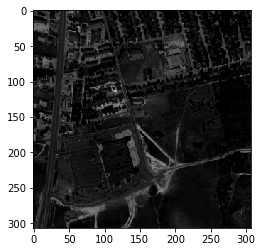

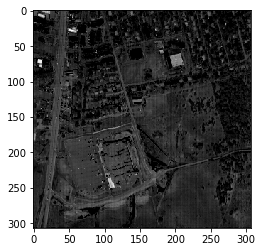

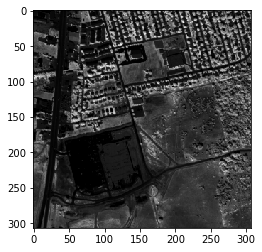

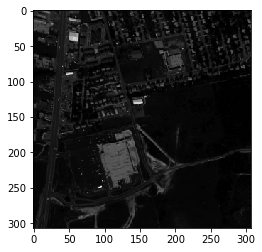

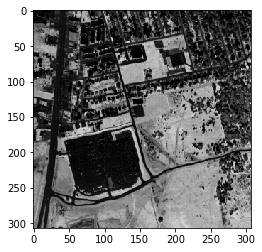

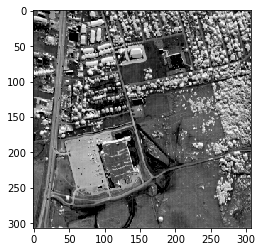

In [64]:
for i in range(0,6):
    fst_row = H[i]
    fst_image = H[i].reshape((307, 307))

    plt.imshow(fst_image, cmap='gray', interpolation='nearest')
    plt.show()

In [65]:
wavelength = hs_image["SlectBands"]

def radiation_expected(wavelength):
    return 3.8 * 10**8 / wavelength

def convertWToReflectivity(W):
    #https://github.com/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Article_Notebooks/Dimensionality_Reduction_on%C2%A0HSI_using_PCA.ipynb
    if(len(wavelength) != len(W)): return None
    newW = []

    for i in range(len(W)):
        newRow = []
        for j in range(len(W[i])):
            # val =( W[i][j] / radiation_expected(wavelength[i])) 
            val = W[i][j]/1000
            newRow += [val]
        newW += [newRow]

    newW = np.array(newW)
    print(newW.shape)
    return newW

def plot_endmembers(W, n_comps, title="Endmembers", ordering=None):
    if(ordering == None): ordering = range(n_comps)
    W_t = W.transpose()
    bands = range(162)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.xlabel("Bands")
    plt.ylabel("Reflectance")
    plt.title(title)
    for i in range(n_comps):
        plt.plot(bands, W_t[ordering[i]], color = colors[i])
    plt.show()

(162, 6)
(162, 6)
(162, 6)


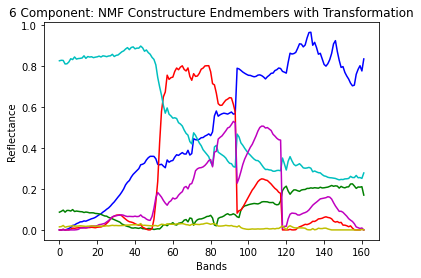

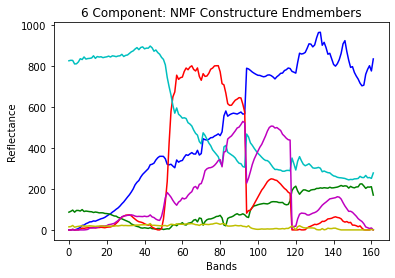

In [66]:
print(W.shape)

W_reflection = convertWToReflectivity(W)
# print(W_reflection)
print(W_reflection.shape)

plot_endmembers(W_reflection, 6, title="6 Component: NMF Constructure Endmembers with Transformation")
plot_endmembers(W, 6, title="6 Component: NMF Constructure Endmembers")



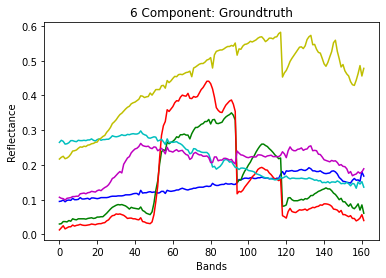

In [67]:
hs_image = sio.loadmat("data/groundTruth_Urban_end6/end6_groundTruth.mat")

W_gt6 = hs_image["M"]
plot_endmembers(W_gt6, 6, title="6 Component: Groundtruth")



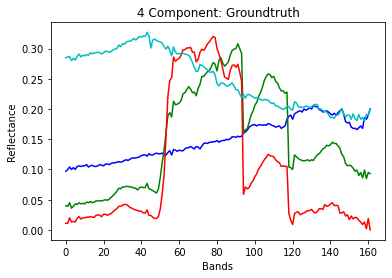

In [68]:
hs_image = sio.loadmat("data/groundTruth/end4_groundTruth.mat")

W_gt4 = hs_image["M"]
plot_endmembers(W_gt4, 4, title="4 Component: Groundtruth")


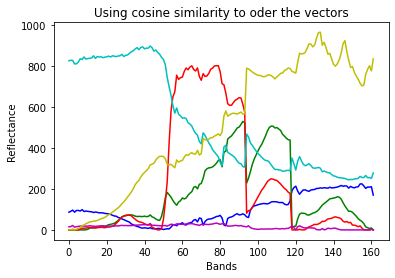

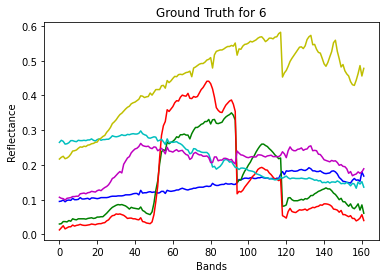

In [74]:
from scipy import spatial

def find_similarity(W, W_gt = W_gt6, num_components=6):
    if(W.shape != W_gt.shape): return None, None
    l = list(permutations(range(num_components)))

    best_error = 1000000000000000
    permutation = None

    dp = np.full((num_components, num_components), -1.0)

    for perm in l:
        current_error = 0
        for i in range(len(perm)):
            if(dp[perm[i]][i] == -1):
                dp[perm[i]][i] = cosine_similarity(W[:,perm[i]], W_gt[:,i])
                
            current_error += dp[perm[i]][i]
            
        
        if(current_error < best_error):
            best_error = current_error
            permutation = perm

    return best_error, permutation



def cosine_similarity(vec1, vec2):
    return spatial.distance.cosine(vec1, vec2)
    

err, best_ordering = find_similarity(W)
plot_endmembers(W,6, title="Using cosine similarity to order the vectors", ordering=best_ordering)
plot_endmembers(W_gt6,6, title="Ground Truth for 6")


